# Previsao de vendas

Vamos fazer um pouco de EDA (Exploratory Data Analysis), preprocessamento e transformacao de dados, bem como implementar uma solucao com Regressao Linear para predicao de precos de produtos.

Vamos usar uma base de dados real, fornecida [neste datahack](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/).

Neste dataset sao fornecidas informacoes sobre as lojas (localizacao, tamanho, etc), sobre produtos (peso, categoria, preco, etc) e dados historicos de vendas. A partir dessas informacoes, temos que fazer uma previsão das vendas dos produtos nas lojas.

Um preditor como esse eh util para o tomador de decisao em varias situacoes, como por exemplo: planejar a reposicao de estoque das lojas de uma rede, planejar os produtos que serao disponibilizados em uma nova loja, etc.   

## Imports iniciais

In [125]:
import requests
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carga dos dados

In [126]:
orig_url='https://drive.google.com/file/d/1JRTf0BnqwgT0pXz9XVWJSBAXBzCHsqKb/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw, encoding = "ISO-8859-1")

## Observacoes iniciais

In [127]:
df.head() # 5 primeiras linhas do dataset

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [128]:
df.shape

(8523, 12)

#### Alguma coluna para remover a partir desta primeira observacao?


In [129]:
df.drop(axis=1, columns=['Item_Identifier', 'Outlet_Identifier'], inplace=True) # Id do produto e da loja são da lógica interna do BD e não influenciam na venda


In [130]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [131]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Algo estranho observado?


In [132]:
# Visibilidade zero não faz sentido, provavelmente era dado faltante
new_min = df[df['Item_Visibility'] > 0]['Item_Visibility'].min()
df['Item_Visibility'] = df['Item_Visibility'].replace(0, new_min)
df.replace({'Item_Visibility': {0: new_min}}, inplace=True)


In [133]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066353,140.992782,1997.831867,2181.288914
std,4.643456,0.051321,62.275067,8.371760,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Tratando **Valores Faltantes**

In [134]:
df.isnull().sum()

,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0
Outlet_Type,0
Item_Outlet_Sales,0


#### O que fazer com Item_Weight ?


In [135]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())
df.fillna({'Item_Weight': df['Item_Weight'].mean()}, inplace=True)
# Essa solução com a média não é apropriada se os tamanhos não variarem grosseiramente


In [136]:
df.isnull().sum()

,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0
Outlet_Type,0
Item_Outlet_Sales,0


#### O que fazer com Outlet_Size?


In [137]:
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
High,932


In [138]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('Medium')
df.fillna({'Outlet_Size': 'Medium'}, inplace=True)


In [139]:
df.isnull().sum()

,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0
Outlet_Type,0
Item_Outlet_Sales,0


## **Consistencia** dos Atributos **Categoricos**

#### Como analisar se os valores estao consistentes?

In [140]:
categorical_attributes = ['Item_Type','Outlet_Location_Type','Outlet_Type', 'Item_Fat_Content', 'Outlet_Size']

for catg in categorical_attributes:
   print(df[catg].value_counts())
   print('\n\n')

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64



Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64



Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64



Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64



Outlet_Size
Medium    5203
Small     2388
High       932
Name: count, dtype: int64





#### Algo a corrigir?

In [141]:
# Algumas classes se repetem com nomes ligeiramente diferente, precisamos tratar isso
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

## Vamos dar mais uma olhada no dataframe

In [142]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.003575,Fruits and Vegetables,182.0950,1998,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.003575,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [143]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066353,140.992782,1997.831867,2181.288914
std,4.226124,0.051321,62.275067,8.371760,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Ajustes de **Escala**

In [144]:
# Esta base de dados foi gerada em 2013
df['Outlet_Establishment_Year']=(2013-df['Outlet_Establishment_Year'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,14,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,4,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,14,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.003575,Fruits and Vegetables,182.0950,15,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.003575,Household,53.8614,26,High,Tier 3,Supermarket Type1,994.7052


#### Observando a distribuicao

In [145]:
import seaborn as sns

<ipython-input-146-4123146980>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Outlet_Establishment_Year'])


<Axes: xlabel='Outlet_Establishment_Year', ylabel='Density'>

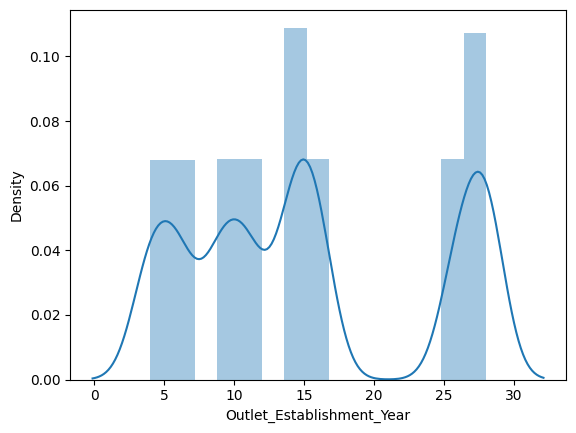

In [146]:
sns.distplot(df['Outlet_Establishment_Year'])

<ipython-input-147-1001071604>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Weight'])


<Axes: xlabel='Item_Weight', ylabel='Density'>

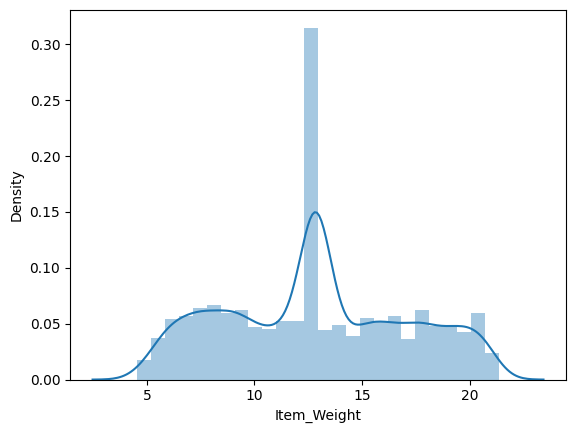

In [147]:
sns.distplot(df['Item_Weight'])

<ipython-input-148-852521860>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Visibility'])


<Axes: xlabel='Item_Visibility', ylabel='Density'>

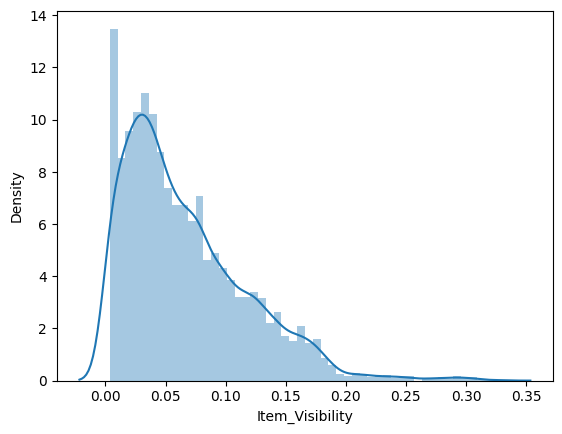

In [148]:
sns.distplot(df['Item_Visibility'])

<ipython-input-149-3329567677>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_MRP'])


<Axes: xlabel='Item_MRP', ylabel='Density'>

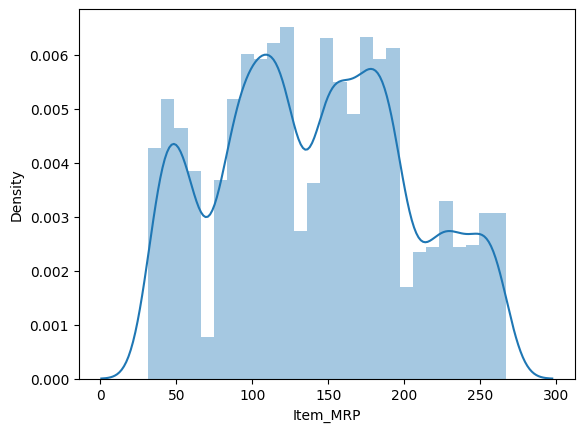

In [149]:
sns.distplot(df['Item_MRP'])

#### Testando a normalidade

In [150]:
from scipy import stats

df_Norm = df[['Item_Weight', 'Item_Visibility',
    'Item_MRP', 'Outlet_Establishment_Year']]

for idx, col_name in enumerate(df_Norm.columns):
     nor = stats.normaltest(df[col_name])[1] > 0.05
     print("Teste de normalidade para {}: {}".format(col_name, nor))

Teste de normalidade para Item_Weight: False
Teste de normalidade para Item_Visibility: False
Teste de normalidade para Item_MRP: False
Teste de normalidade para Outlet_Establishment_Year: False


#### Fazendo o ajuste de escala

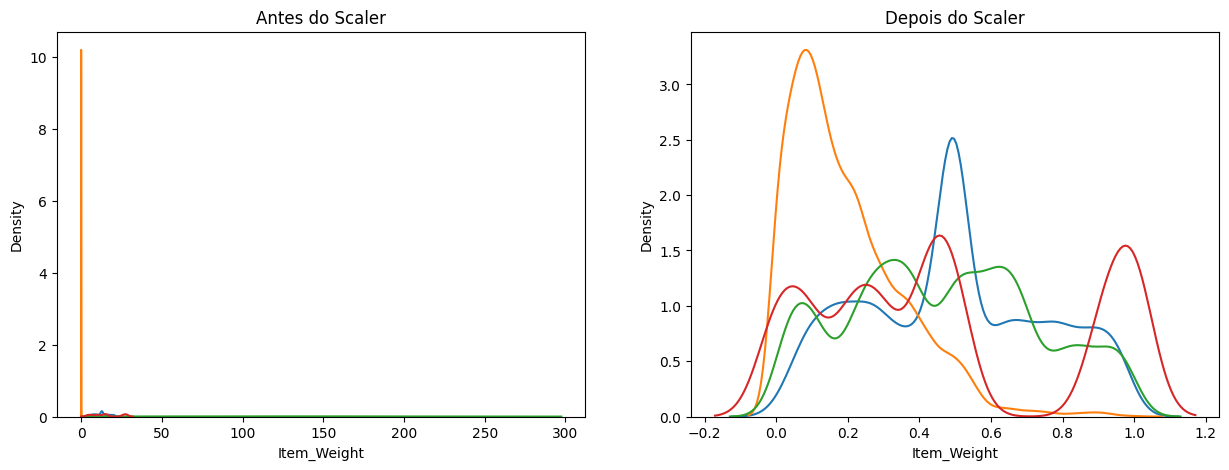

In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

#Plot antes
ax1.set_title('Antes do Scaler')
sns.kdeplot(df['Item_Weight'], ax=ax1)
sns.kdeplot(df['Item_Visibility'], ax=ax1)
sns.kdeplot(df['Item_MRP'], ax=ax1)
sns.kdeplot(df['Outlet_Establishment_Year'], ax=ax1)

df[['Item_Weight', 'Item_Visibility',
    'Item_MRP', 'Outlet_Establishment_Year']] = scaler.fit_transform(df[['Item_Weight', 'Item_Visibility',
                                                                         'Item_MRP', 'Outlet_Establishment_Year']].values)
#Plot Depois
ax2.set_title('Depois do Scaler')
sns.kdeplot(df['Item_Weight'], ax=ax2)
sns.kdeplot(df['Item_Visibility'], ax=ax2)
sns.kdeplot(df['Item_MRP'], ax=ax2)
sns.kdeplot(df['Outlet_Establishment_Year'], ax=ax2)
plt.show()

## Analisando a relacao entre pares de variaveis

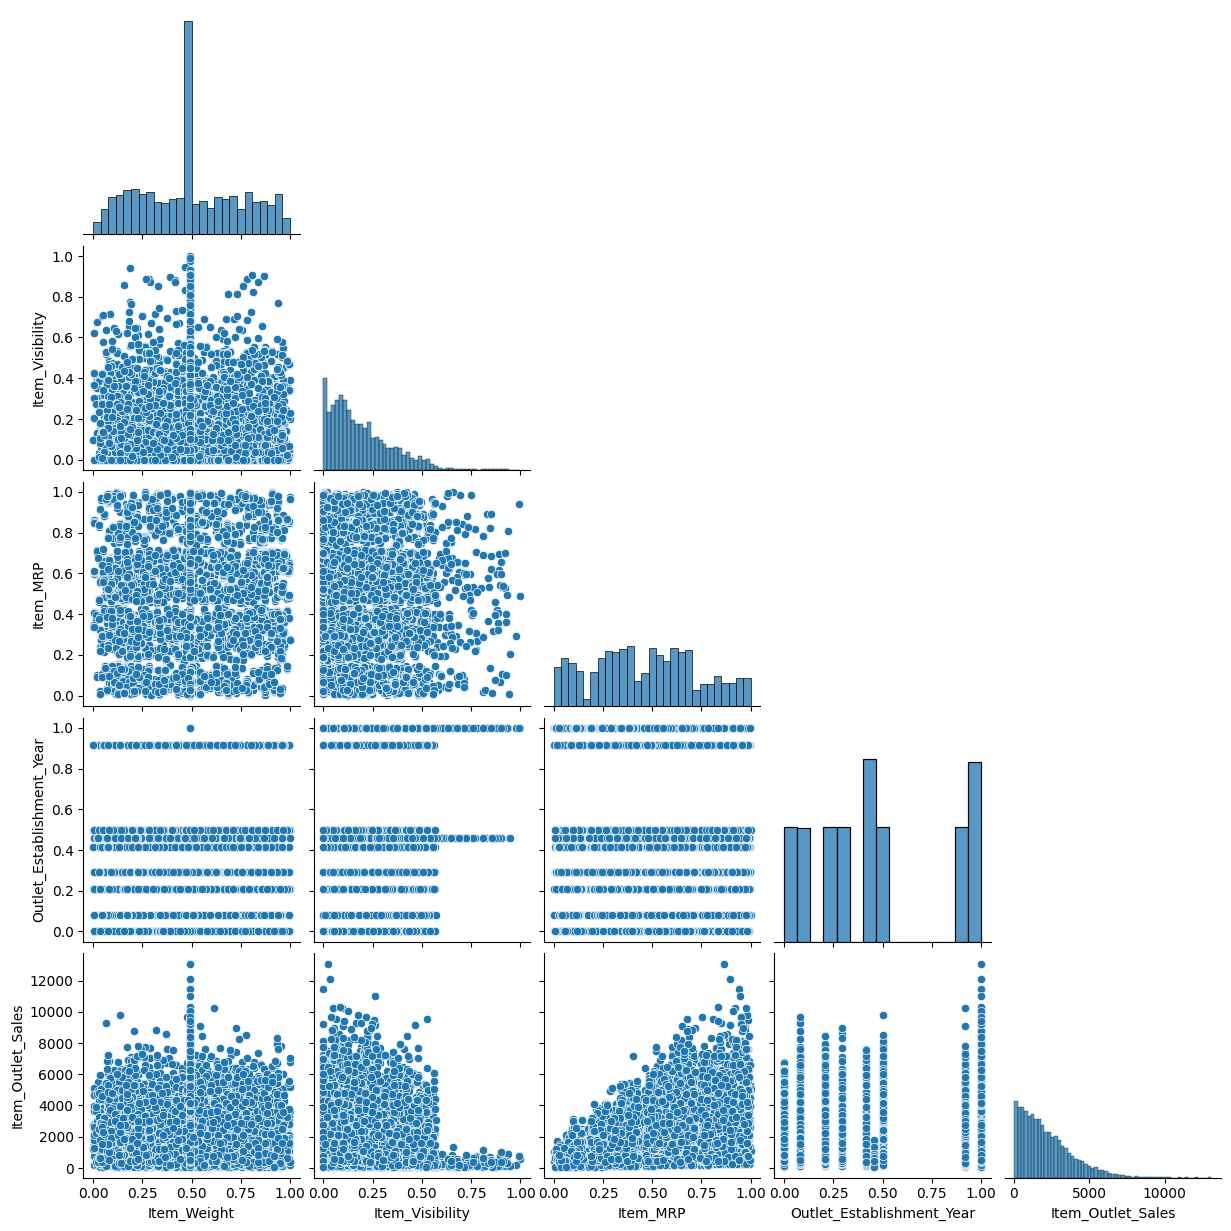

In [152]:
#import seaborn as sns
sns.pairplot(df, corner=True)

## **Codificacao** dos Atributos **Categoricos**

#### Atributos Nominais


In [153]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
nominal_attributes = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type']
df[nominal_attributes] = enc.fit_transform(df[nominal_attributes])


#### Atributos Ordinais


In [154]:
enc = OrdinalEncoder(categories=[['Small', 'Medium', 'High']])
df[['Outlet_Size']] = enc.fit_transform(df[['Outlet_Size']])

#### Observando o dataframe mais uma vez

In [155]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0.282525,0.0,0.038399,4.0,0.927507,0.416667,1.0,0.0,1.0,3735.1380
1,0.081274,1.0,0.048346,14.0,0.072068,0.000000,1.0,2.0,2.0,443.4228
2,0.770765,0.0,0.040593,10.0,0.468288,0.416667,1.0,0.0,1.0,2097.2700
3,0.871986,1.0,0.000000,6.0,0.640093,0.458333,1.0,2.0,0.0,732.3800
4,0.260494,0.0,0.000000,9.0,0.095805,0.916667,2.0,2.0,1.0,994.7052


#### Outras opcoes: Dummy Variables / OneHotEncoder

In [156]:
# dummy = pd.get_dummies(df,columns=['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type'],drop_first=True)
# df = dummy
# df.head()

## Separando Features (X) e Valores Alvo (y)

In [157]:
X = df.drop(columns=['Item_Outlet_Sales']).values
y = df['Item_Outlet_Sales'].values

In [158]:
print('X:', X[:1])
print()
print('y:', y[:1])

X: [[0.28252456 0.         0.03839895 4.         0.92750715 0.41666667
  1.         0.         1.        ]]

y: [3735.138]


## Ajustando a escala novamente

Eh interessante fazer um ajuste de escala considerando as variaveis recentemente codificadas. Como iremos usar o mesmo Scaler, por simplificacao, iremos fazer no dataframe completo (apenas nas features). Isso poderia ser feito somente nas variaveis que ainda nao passaram por ajuste de escala.



In [159]:
X = scaler.fit_transform(X)

## Treino, Teste e Avaliacao (Regressao Linear)

#### Treino

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

est = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
est.fit(X_train, y_train)

LinearRegression()

#### Teste (predicoes)

In [161]:
y_pred = est.predict(X_test)

#### Avaliacao da Eficacia

In [162]:
print('MAE:', mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mean_squared_error(y_test, y_pred))

rmse = np.sqrt(mse)
print('RMSE: ', rmse)

print('r2_score: ', r2_score(y_test,y_pred))

MAE: 877.8112811558439
MSE: 1337547.5759476107
RMSE:  1156.523919314949
r2_score:  0.5008094885854146


## Treino, Teste e Avaliacao (Regressao Polinomial)

#### Treino


In [163]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

Input = [('polyfeatues', PolynomialFeatures(degree=2)), ('regmodel', LinearRegression())]
pipe = Pipeline(Input)

pipe.fit(X_train, y_train)

Pipeline(steps=[('polyfeatues', PolynomialFeatures()),
                ('regmodel', LinearRegression())])

#### Teste (Predicoes)

In [164]:
y_pred = pipe.predict(X_test)

#### Analisando a eficacia

In [165]:
print('MAE:', mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mean_squared_error(y_test, y_pred))

rmse = np.sqrt(mse)
print('RMSE: ', rmse)

print('r2_score: ', r2_score(y_test,y_pred))

MAE: 758.4312194378141
MSE: 1100383.9052735055
RMSE:  1048.9918518623037
r2_score:  0.5893221188512139


## Imprimindo os coeficientes

#### Regressao Linear

In [166]:
df_X = df.drop(columns=['Item_Outlet_Sales'])
for idx, col_name in enumerate(df_X.columns):
    print("O coeficiente para {} eh {}".format(col_name, est.coef_[idx]))

O coeficiente para Item_Weight eh -108.12180231878735
O coeficiente para Item_Fat_Content eh 37.15334996610136
O coeficiente para Item_Visibility eh -523.4673812787793
O coeficiente para Item_Type eh -35.41582377076395
O coeficiente para Item_MRP eh 3698.059181958746
O coeficiente para Outlet_Establishment_Year eh -5.203925416684356
O coeficiente para Outlet_Size eh 650.4859712031168
O coeficiente para Outlet_Location_Type eh -833.787133755504
O coeficiente para Outlet_Type eh 3042.1257681246007


#### Regressao Polinomial

In [167]:
poly_est = pipe.named_steps['regmodel']
df_X = df.drop(columns=['Item_Outlet_Sales'])
for idx, col_name in enumerate(df_X.columns):
     print("O coeficiente para {} eh {}".format(col_name, poly_est.coef_[idx]))

O coeficiente para Item_Weight eh 2.478656322074336e-13
O coeficiente para Item_Fat_Content eh 345.46775297678425
O coeficiente para Item_Visibility eh 44.462116022895515
O coeficiente para Item_Type eh 424.89410929190564
O coeficiente para Item_MRP eh -117.97468858666514
O coeficiente para Outlet_Establishment_Year eh 2778.6401042471384
O coeficiente para Outlet_Size eh -2339.9933829144084
O coeficiente para Outlet_Location_Type eh -1588.5688544368913
O coeficiente para Outlet_Type eh -126.96606905673752


## Como seria a eficacia de uma Decision Tree ?

Se tiver curiosidade, voce pode variar os codigos acima para mudar a forma como as features foram preprocessadas e verificar se ha impacto no resultado com a Decision Tree.

In [168]:
from sklearn.tree import DecisionTreeRegressor
est = DecisionTreeRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mean_squared_error(y_test, y_pred))

rmse = np.sqrt(mse)
print('RMSE: ', rmse)

print('r2_score: ', r2_score(y_test,y_pred))

MAE: 1076.3117842327547
MSE: 2423416.8613926927
RMSE:  1556.732752078112
r2_score:  0.09554865623955122


## Observacoes

* Valores "zero" para Item_Visibility podem representar valores faltantes. Neste caso, podemos experimentar substitui-los pela media, por exemplo.

